In [1]:
# 数値計算およびデータ分析用ライブラリ
import numpy as np
import pandas as pd

# グラフ描画用ライブラリ
import matplotlib.pyplot as plt

# 統計および信号処理関数用ライブラリ
from scipy import signal
from scipy.signal import savgol_filter

# ハイパースペクトルイメージ処理用ライブラリ
from spectral import imshow
import spectral.io.envi as envi

# 画像解析用ライブラリ
import cv2

# 乱数生成用モジュール
import random

# 機械学習モデルおよび評価関数
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# 画像処理用ライブラリ
from skimage.filters import threshold_otsu

# ディープラーニングフレームワーク
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# データセット
from keras.datasets import cifar10


C:\Users\tetsu\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### <span style="color: DeepPink; "> 8.2 NIR-HSIデータの構造と読み込み</span>

### <span style="color: blue; ">rawファイルの読み込み</span>

In [2]:
dark_ref=envi.open("dataChapter8/dark.hdr","dataChapter8/dark.raw")
white_ref=envi.open("dataChapter8/white.hdr","dataChapter8/white.raw")
wood_ref=envi.open("dataChapter8/wood.hdr","dataChapter8/wood.raw")
print(white_ref)
print(wood_ref)

	Data Source:   '.\dataChapter8/white.raw'
	# Rows:              1
	# Samples:         320
	# Bands:           256
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16
	Data Source:   '.\dataChapter8/wood.raw'
	# Rows:            280
	# Samples:         320
	# Bands:           256
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16


C:\Users\tetsu\anaconda3\Lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


### <span style="color: blue; ">反射率の計算</span>

In [3]:
#配列に変換
white=np.array(white_ref.load())
dark=np.array(dark_ref.load())
wood=np.array(wood_ref.load())
#波長データを抽出
wave =wood_ref.metadata['wavelength']
wave=np.array(wave,dtype=float)
#反射率の算出
ref_sample=np.divide(np.subtract(wood,dark),np.subtract(white,dark))
print("white",white.shape)
print("dark",dark.shape)
print("wood",wood.shape)
print("反射率",ref_sample.shape)

white (1, 320, 256)
dark (1, 320, 256)
wood (280, 320, 256)
反射率 (280, 320, 256)


C:\Users\tetsu\AppData\Local\Temp\ipykernel_16564\461322572.py:9: RuntimeWarning: invalid value encountered in divide
  ref_sample=np.divide(np.subtract(wood,dark),np.subtract(white,dark))


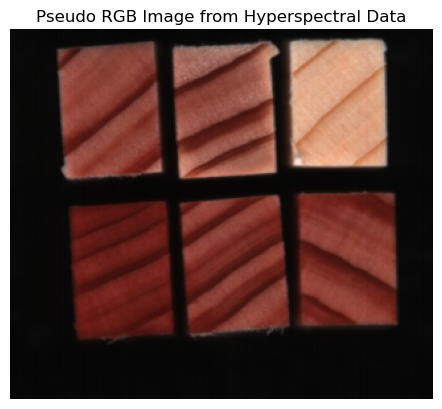

In [4]:
target_wavelengths = [1320, 1400, 1540]

# 波長データから最も近い波長のインデックスを見つける
def find_nearest(wavelengths, value):
    index = np.abs(wavelengths - value).argmin()
    return index
# 各波長に対応するインデックスを取得
indices = [find_nearest(wave, wl) for wl in target_wavelengths]

# RGBチャンネルとして指定されたバンドを抽出
R = wood_ref[:, :, [indices[0]]].squeeze()
G = wood_ref[:, :, [indices[1]]].squeeze()
B = wood_ref[:, :, [indices[2]]].squeeze()

# RGB画像の作成
RGB_image = np.stack([R, G, B], axis=-1)

# RGB画像のデータを0から1の範囲に正規化
RGB_image_normalized = (RGB_image - RGB_image.min()) / (RGB_image.max() - RGB_image.min())

# 画像の表示
plt.imshow(RGB_image_normalized)
plt.title('Pseudo RGB Image from Hyperspectral Data')
plt.axis('off')  # 軸の非表示
plt.show()

### <span style="color: DeepPink; "> 8.3 スペクトルと画像の抽出</span>

### <span style="color: blue; ">特定の位置のスペクトルを出力</span>

In [5]:
def get_image_at_wavelength(sample, waveinf, wavelength):
    """
    特定の波長での画像を出力する関数。

    Parameters:
    ref_sample (numpy.ndarray): HSIデータ (形状: (高さ, 幅, 波長数))
    wave (numpy.ndarray): 波長データ (形状: (波長数,))
    wavelength (float): 抽出したい特定の波長

    Returns:
    numpy.ndarray: 指定された波長での画像 (形状: (高さ, 幅))
    """
    # 波長に最も近いインデックスを見つける
    idx = np.argmin(np.abs(waveinf - wavelength))
    # その波長での画像を取得
    image = ref_sample[:, :, idx]
    plt.figure(figsize=(6, 6))
    img = plt.imshow(image, cmap='viridis')
    plt.colorbar(img, orientation='horizontal', shrink=0.8, aspect=40, pad=0.05)
    plt.title(f'Image at {wavelength} nm')
    plt.show()

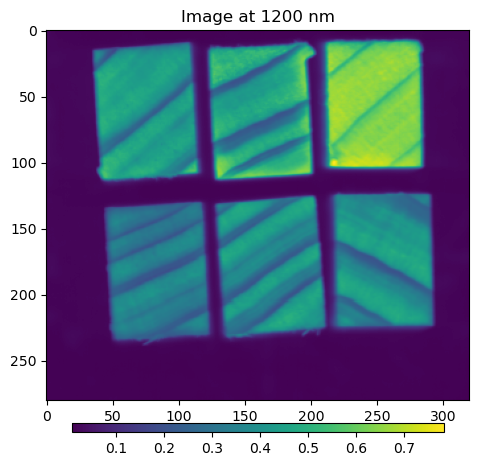

In [6]:
get_image_at_wavelength(ref_sample, wave, 1200)

### <span style="color: blue; ">特定の波長の画像を出力</span>

In [7]:
def plot_spectrum_and_sum_image(sample, waveinf, x1, y1, x2, y2):
    """
    特定の2箇所の位置のスペクトルとスペクトルの波長方向積算値の画像を表示する関数。

    Parameters:
    sample (numpy.ndarray): HSIデータ (形状: (高さ, 幅, 波長数))
    waveinf (numpy.ndarray): 波長データ (形状: (波長数,))
    x1, y1 (int): 1つ目の指定されたピクセルの座標
    x2, y2 (int): 2つ目の指定されたピクセルの座標

    Returns:
    None
    """
    # 特定の位置のスペクトルを取得
    spectrum1 = sample[y1, x1, :]
    spectrum2 = sample[y2, x2, :]

    # スペクトルの波長方向積算値の画像を計算
    sum_image = np.sum(sample, axis=2)
    
    plt.figure(figsize=(8, 8))

    # スペクトルの波長方向積算値の画像を表示
    plt.subplot(2, 1, 1)
    plt.imshow(sum_image, cmap='gray')
    plt.colorbar(label='Sum')
    plt.scatter(x1, y1, color='magenta', marker='x')  # 1つ目の位置にマゼンダのマークを付ける
    plt.scatter(x2, y2, color='cyan', marker='x')    # 2つ目の位置にシアンのマークを付ける
    plt.title('Sum Image')

    # 特定の位置のスペクトルを表示
    plt.subplot(2, 1, 2)
    plt.plot(waveinf, spectrum1, color='magenta', label=f'Spectrum at ({x1}, {y1})')
    plt.plot(waveinf, spectrum2, color='cyan', label=f'Spectrum at ({x2}, {y2})')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title('Spectra at Specified Locations')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 使用例
# plot_spectra_and_sum_image(sample, waveinf, x1, y1, x2, y2)


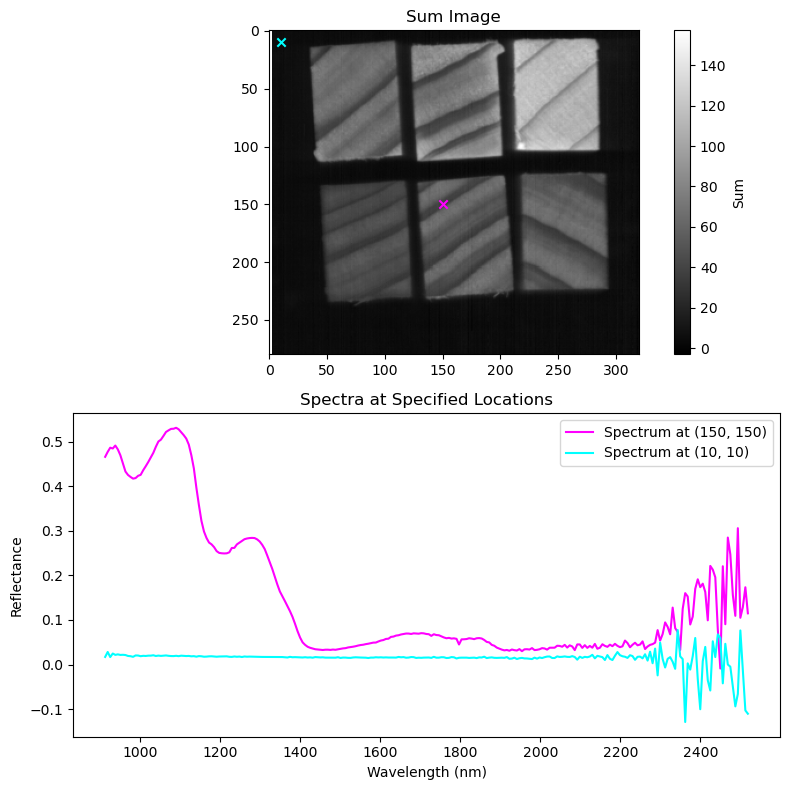

In [8]:
plot_spectrum_and_sum_image(ref_sample, wave, 150,150,10,10)

### <span style="color: blue; ">2,200nm以上でノイジーな理由</span>

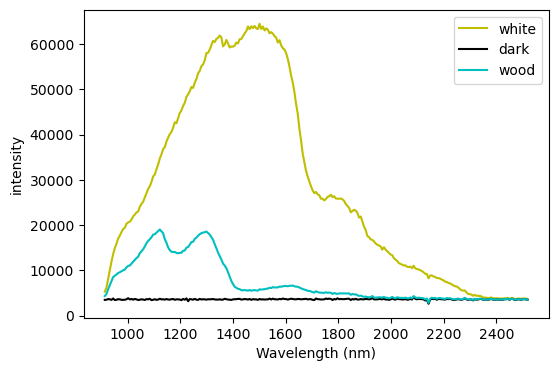

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(wave,white[0,150,:],'y-',label= "white")
plt.plot(wave,dark[0,150,:],'k-',label= "dark")
plt.plot(wave,wood[150,150,:],'c-',label= "wood")
plt.xlabel('Wavelength (nm)')
plt.ylabel('intensity')
plt.legend()

### <span style="color: DeepPink; "> 8.4 木材領域のスペクトルと画像を抽出</span>

### <span style="color: blue; ">特定の波長の画像を出力</span>

In [10]:
def extract_image(sample, waveinf, minz, maxz):
    """
    特定の波長範囲での画像データと波長情報を抽出する関数。
    Parameters:
    sample (numpy.ndarray): HSIデータ (形状: (高さ, 幅, 波長数))
    waveinf (numpy.ndarray): 波長データ (形状: (波長数,))
    minz (float): 抽出する波長範囲の最小値
    maxz (float): 抽出する波長範囲の最大値
    Returns:
    tuple: 抽出された画像データと波長情報 (numpy.ndarray, numpy.ndarray)
    """
    # 指定された波長範囲のインデックスを見つける
    idx1 = np.argmin(np.abs(waveinf - minz))
    idx2 = np.argmin(np.abs(waveinf - maxz)) + 1  # idx2のインデックスを含めるために+1

    # 特定の波長範囲での画像データを抽出
    sample_extract = sample[:, :, idx1:idx2]
    # 対応する波長情報を抽出
    wave_extract = waveinf[idx1:idx2]

    return sample_extract, wave_extract

In [11]:
sample_extract, wave_extract=extract_image(ref_sample, wave, 950, 2200)

### <span style="color: blue; ">抽出した波長領域で再度plot_spectrum_and_sum_image使用</span>

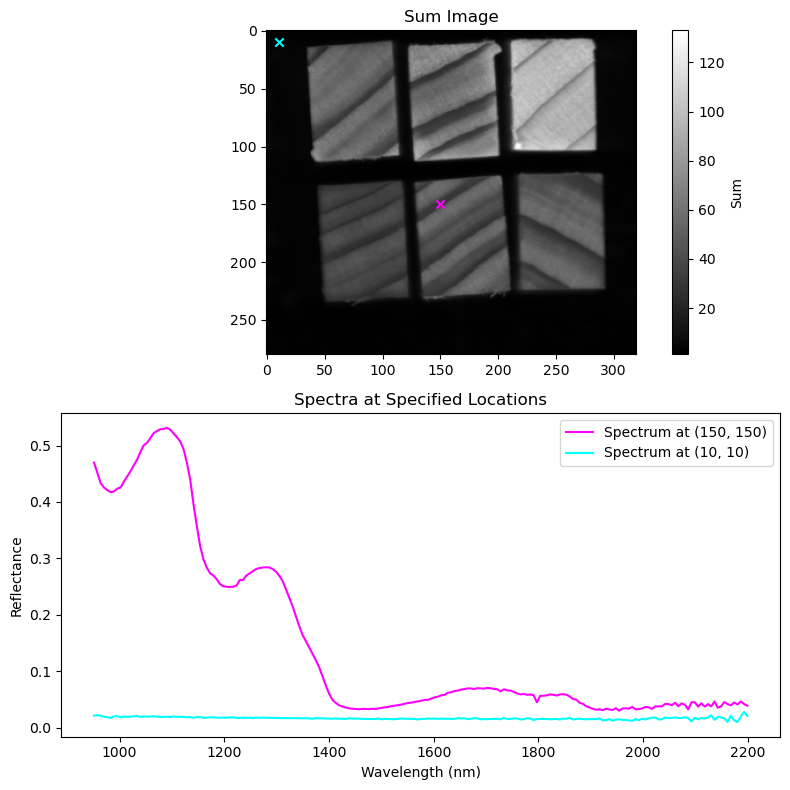

In [12]:
plot_spectrum_and_sum_image(sample_extract, wave_extract, 150,150,10,10)

### <span style="color: blue; ">指定する波長とPC1-PC3スコアを用いて試料領域の抽出（大津の二値化法）</span>

In [13]:
def extract_sample_region(sample, waveinf, wavelength):
    """
    指定した波長に基づいてサンプル領域を抽出し、PCAによる解析を行う関数。
    パラメーター:
    sample (numpy.ndarray): HSIデータ (形状: (高さ, 幅, 波長数))
    waveinf (numpy.ndarray): 波長情報 (形状: (波長数,))
    wavelength (float): 抽出する特定の波長
    戻り値:
    None
    """
    #①wavelengthで指定される波長での画像を抽出
    #①-1指定された波長に最も近いインデックスを見つける
    idx = np.argmin(np.abs(waveinf - wavelength))
    #①-2指定された波長での画像を抽出
    image = sample[:, :, idx]
    #②PCAスコアマップを作成
    #②-1sampleを高さ×幅, 波長数にreshape
    reshaped_sample = sample.reshape((-1, sample.shape[2]))
    #②-2PCAを実行し、第1－第3主成分スコアの画像を作成
    pca = PCA(n_components=3)
    pca_scores = pca.fit_transform(reshaped_sample)
    #②-3Reshapeでサイズを(y,x,3)に戻す
    pc_images = pca_scores.reshape((sample.shape[0], sample.shape[1], 3))

    #③大津の二値化法を使用して二値化画像を作成(木材部が1、背景部が0)
    binary_image = (image > threshold_otsu(image)).astype(int)
    pc1_binary = (pc_images[:, :, 0] > threshold_otsu(pc_images[:, :, 0])).astype(int)
    pc2_binary = (pc_images[:, :, 1] > threshold_otsu(pc_images[:, :, 1])).astype(int)
    pc3_binary = (pc_images[:, :, 2] > threshold_otsu(pc_images[:, :, 2])).astype(int)
    
    # 画像を表示
    plt.figure(figsize=(12, 9))
    plt.subplot(3, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Image at {wavelength} nm')
    plt.subplot(3, 4, 5)
    plt.imshow(binary_image, cmap='gray')
    plt.title('binary image')
    plt.subplot(3, 4, 2)
    plt.imshow(pc_images[:, :, 0], cmap='gray')
    plt.title('PC1 score image')
    plt.subplot(3, 4, 6)
    plt.imshow(pc1_binary, cmap='gray')
    plt.title('PC1 binary image')
    plt.subplot(3, 4, 10)
    plt.plot(pca.components_[0])
    plt.title('PC1 loading')
    plt.subplot(3, 4, 3)
    plt.imshow(pc_images[:, :, 1], cmap='gray')
    plt.title('PC2 score image')
    plt.subplot(3, 4, 7)
    plt.imshow(pc2_binary, cmap='gray')
    plt.title('PC2 binary image')
    plt.subplot(3, 4, 11)
    plt.plot(pca.components_[1])
    plt.title('PC2 loading')
    plt.subplot(3, 4, 4)
    plt.imshow(pc_images[:, :, 2], cmap='gray')
    plt.title('PC3 score image')
    plt.subplot(3, 4, 8)
    plt.imshow(pc3_binary, cmap='gray')
    plt.title('PC3 binary image')
    plt.subplot(3, 4, 12)
    plt.plot(pca.components_[2])
    plt.title('PC3 loading')
    plt.tight_layout()
    plt.show()
    
    return binary_image,pc1_binary,pc2_binary,pc3_binary

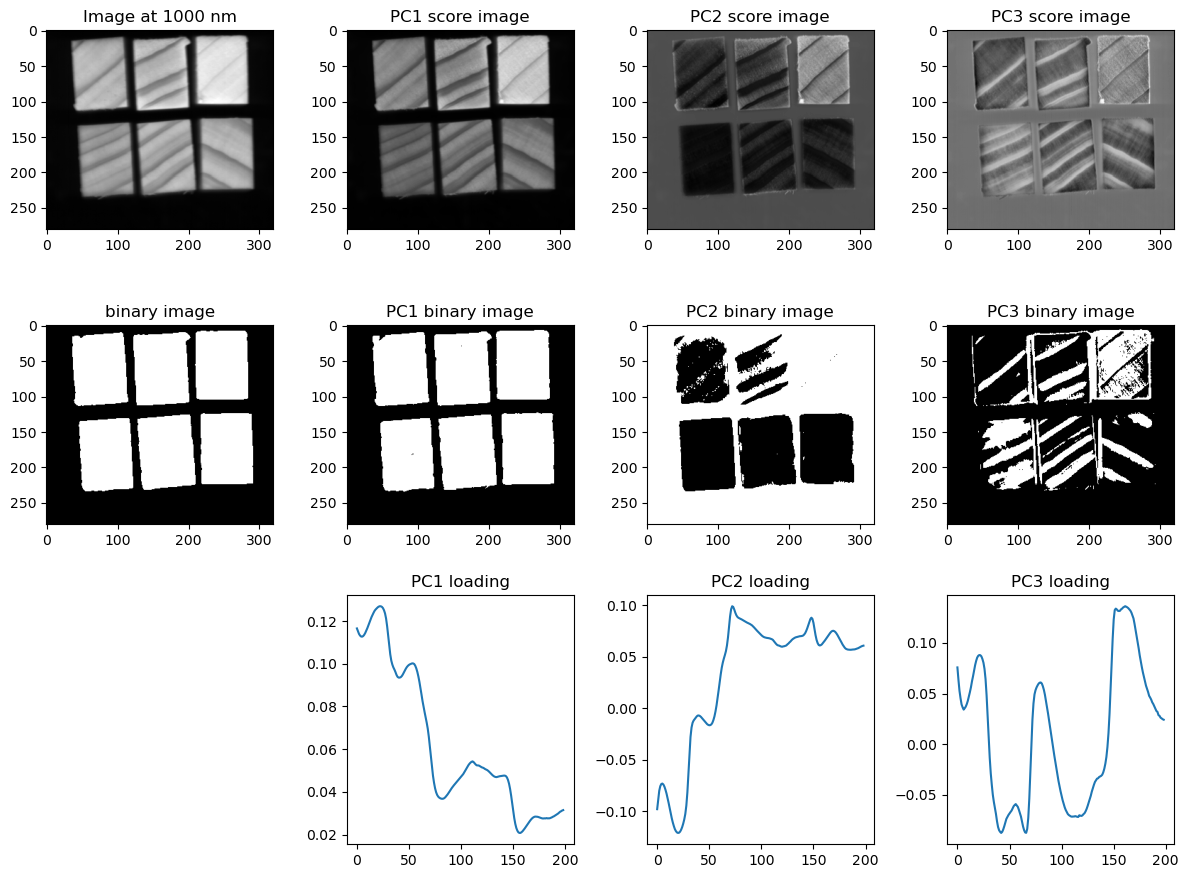

In [14]:
binary_image,pc1_binary,pc2_binary,pc3_binary=extract_sample_region(sample_extract, wave_extract,1000)

### <span style="color: blue; ">画像解析（connectedComponentsWithStats）と組み合わせることで、各試料の平均スペクトルを抽出</span>

In [15]:
def analyze_binary_image(sample, waveinf, binary_im):
    """
    バイナリ画像を解析し、特定の領域をマゼンダで塗りつぶし、シアンで数字を表示する関数。
    Parameters:
    sample (numpy.ndarray): HSIデータ (形状: (高さ, 幅, 波長数))
    waveinf (numpy.ndarray): 波長データ (形状: (波長数,))
    binary_image (numpy.ndarray): バイナリ画像 (形状: (高さ, 幅))
    Returns:
    None
    """
    #①波長方向で積算した画像を作成
    sum_image = np.sum(sample, axis=2)
    binary_im = (binary_im * 255).astype(np.uint8)

    # ②connectedComponentsWithStatsで連結成分を解析
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_im)
    # 画像を表示
    plt.figure(figsize=(6, 6))
    #③connectedComponentsWithStatsの結果をマーク
    marked_image = sum_image.copy()
    for i in range(1, num_labels):  # 背景をスキップ
        print(f'{i}番目の情報は{stats[i]}です')
        marked_image[labels == i] = 100
        x, y = int(centroids[i][0]), int(centroids[i][1])
        cv2.putText(marked_image, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    plt.imshow(marked_image, cmap='magma')
    plt.title('connectedComponentsWithStats')

    plt.tight_layout()
    plt.show()
    return num_labels, labels, stats, centroids

1番目の情報は[ 210    8   75   97 7074]です
2番目の情報は[  37   10   79  104 7270]です
3番目の情報は[ 123   10   81  103 7440]です
4番目の情報は[ 218  124   74  100 7239]です
5番目の情報は[ 129  126   82  106 7584]です
6番目の情報は[  46  131   77  103 7187]です


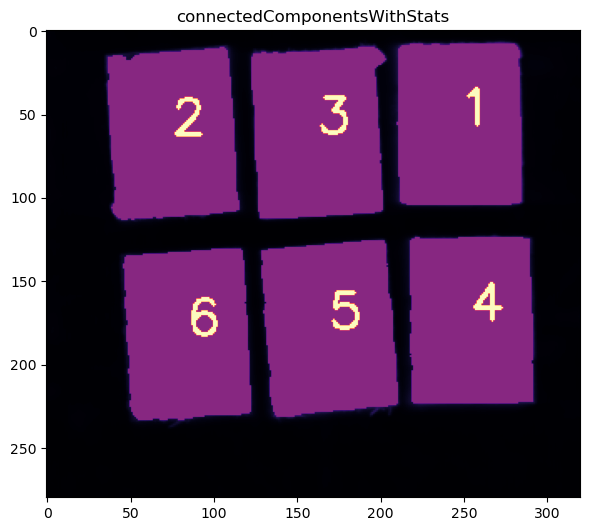

In [18]:
num_labels, labels, stats, centroids=analyze_binary_image(sample_extract, wave_extract, binary_image)

### <span style="color: DeepPink; "> 8.5 含水率予測値のマッピング(PLSr)</span>

In [19]:
#含水率データを読み込み
mc=pd.read_csv('dataChapter8/HSI_mc.csv') 
mc=mc.rename(columns={'Unnamed: 0':''})
mc=mc.set_index('')
print(mc)

           mc
             
1    9.808280
2   65.889571
3   96.082474
4  104.445664
5   92.848572
6  120.367111


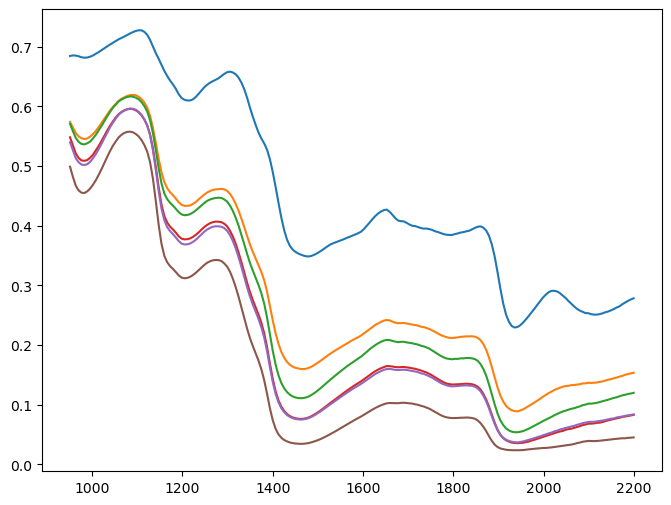

In [20]:
average_spectra = []  # 空のリストを用意して、平均スペクトルを格納します。
sample_order = [1, 3, 2, 4, 5, 6]  #①サンプルの順序を指定します。

# 各ラベルに対して処理を行います。
for label in sample_order:  
    indices = np.where(labels == label)  #②ラベルに該当するピクセルのインデックスを取得します。
    component_spectra = sample_extract[indices[0], indices[1], :]  #③対応するスペクトルを抽出します。
    avg_spectrum = np.mean(component_spectra, axis=0)  #④平均スペクトルを計算します。
    average_spectra.append(avg_spectrum)  # リストに平均スペクトルを追加します。

average_spectra = np.array(average_spectra)  # リストをNumPy配列に変換します。

# 平均スペクトルをプロットします。
plt.figure(figsize=(8, 6))
plt.plot(wave_extract, average_spectra.T)

### <span style="color: blue; ">PLSrによる含水率イメージング作成</span>

In [21]:
def analyze_spectra(sample, waveinf, labelsin, sample_order, prop, n_components, filter_size=0, vmin=None, vmax=None):
    """
    PLS回帰を用いてスペクトルを分析し、様々なプロットを表示する関数。

    引数:
    spectra (numpy.ndarray): 反射率データ (形状: (y, x, 波長数))
    waveinf (numpy.ndarray): 波長情報 (形状: (波長数,))
    labelsin (numpy.ndarray): 試料領域情報 (形状: (y, x))
    sample_order (list): 試料領域の順序
    prop (numpy.ndarray): PLS回帰の目的変数
    n_components (int): PLS回帰の成分数
    filter_size (int): ガウシアンフィルタのサイズ (デフォルト: 0, フィルタリングなし)
    vmin (float): 予測プロパティマップの最小値 (オプション)
    vmax (float): 予測プロパティマップの最大値 (オプション)

    戻り値:
    numpy.ndarray: 各領域の平均スペクトル
    """
    # 平均スペクトルを計算
    average_spectra = []
    for label in sample_order:
        indices = np.where(labelsin == label)
        component_spectra = sample[indices[0], indices[1], :]
        avg_spectrum = np.mean(component_spectra, axis=0)
        average_spectra.append(avg_spectrum)
    average_spectra = np.array(average_spectra)

    # 平均スペクトルをプロット
    plt.figure(figsize=(8, 6))
    plt.plot(waveinf, average_spectra.T)
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')
    plt.title('Average Spectra')
    plt.show()

    # 指定した成分数でPLS回帰を実行
    plsr = PLSRegression(n_components=n_components)
    plsr.fit(average_spectra, prop)
    prop_pred = plsr.predict(average_spectra)
    r2 = r2_score(prop, prop_pred)
    mse = mean_squared_error(prop, prop_pred)
    print(f"R2: {r2}")
    print(f"MSE: {mse}")

    # 実測値と予測値の散布図を表示
    plt.figure(figsize=(8, 6))
    plt.scatter(prop, prop_pred, alpha=0.7, color='blue')
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title(f'Measured vs. Predicted (R2: {r2:.2f}, MSE: {mse:.2f})')
    plt.show()

    # 回帰係数スペクトルを表示
    plt.figure(figsize=(8, 6))
    plt.plot(waveinf, plsr.coef_.flatten())
    plt.xlabel('Wavelength')
    plt.ylabel('Regression Coefficient')
    plt.title('Regression Coefficient Spectrum')
    plt.show()

    #①spectraの各ピクセルに対してPLSモデルを適用
    predicted_spectra = np.zeros_like(sample[:, :, 0])#①-1要素がすべて0の行列を作成。
    for label in sample_order:
        indices = np.where(labelsin == label)#①-2ラベルに該当するピクセルのインデックスを取得。
        predicted_spectra[indices] = plsr.predict(sample[indices[0], indices[1], :]).flatten() #①-3各ピクセルでPLS予測

    # ②予測結果をガウシアンフィルタでぼかす (filter_size > 0 の場合)
    if filter_size > 0:
        predicted_spectra = cv2.GaussianBlur(predicted_spectra,(filter_size,filter_size),0)
     # 予測結果を表示
    plt.figure(figsize=(8, 6))
    plt.imshow(predicted_spectra, cmap='jet',vmin=vmin, vmax=vmax)
    plt.colorbar(label='Predicted Property')
    plt.title('Predicted Property Map')
    plt.show()

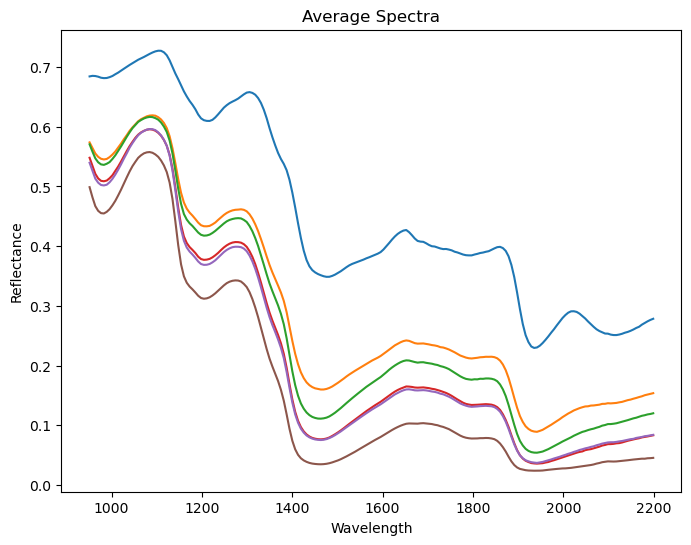

R2: 0.9788960207929477
MSE: 27.301339112674487


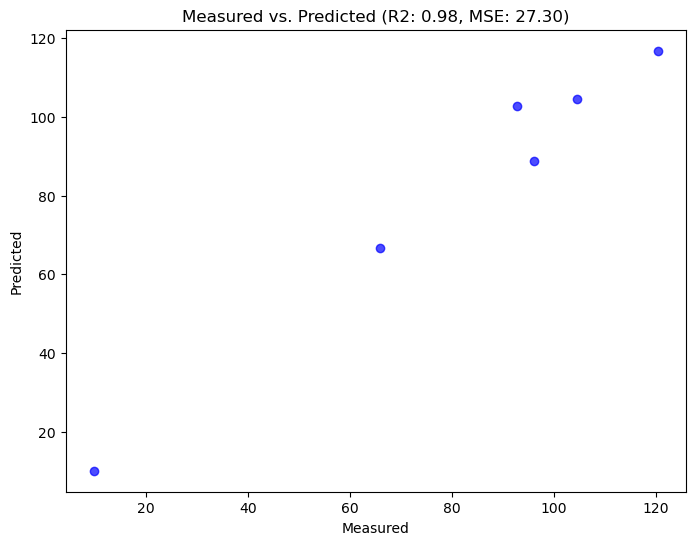

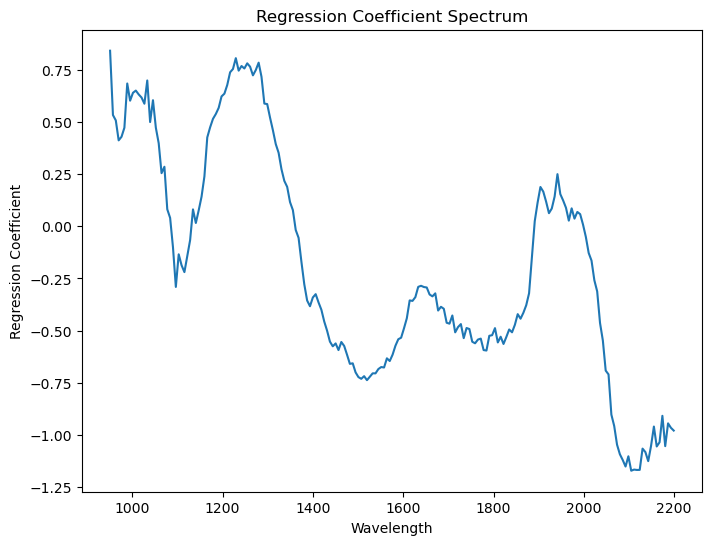

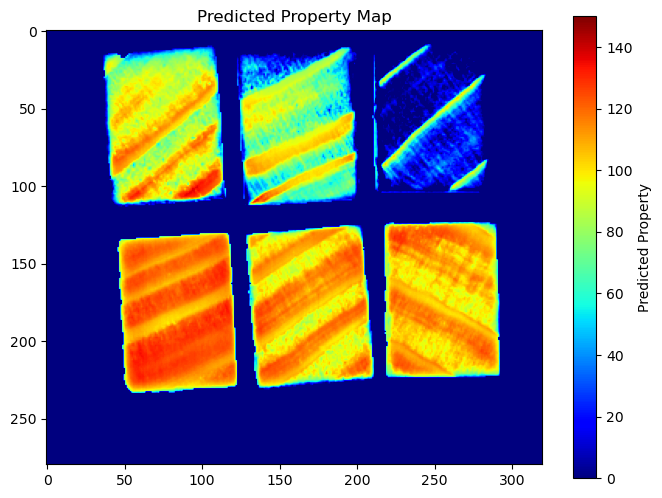

In [22]:
analyze_spectra(sample_extract, wave_extract, labels, [1,3,2,4,5,6],mc,3,1,0,150)

### <span style="color: DeepPink; "> 8.6 PCA画像にCNNを適用</span>

### <span style="color: blue; ">PCAスコアを用いて疑似RGB画像を作成</span>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\tetsu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tetsu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12467 (\N{KATAKANA LETTER KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tetsu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


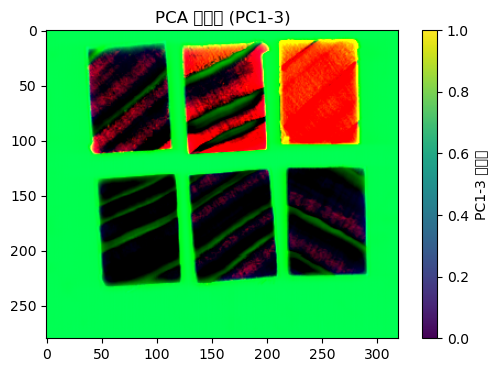

C:\Users\tetsu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tetsu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tetsu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tetsu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12451 (\N{KATAKANA LETTER SMALL I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tetsu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Use

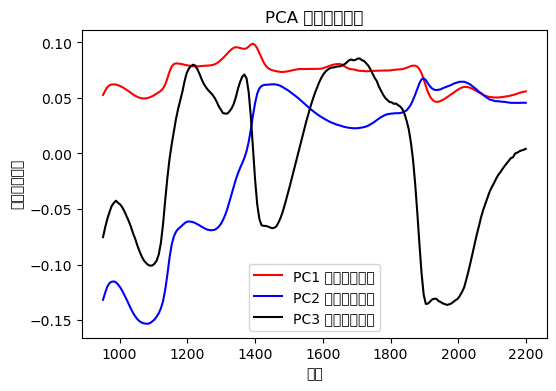

In [23]:
# ラベルが指定された領域からすべてのスペクトルを抽出
wood_spectra = sample_extract[labels > 0]  # ①ラベルが0より大きい領域からスペクトルを抽出

#②抽出したスペクトルでPCAを実行
pca = PCA(n_components=3)  # 3つの成分でPCAを初期化
pca.fit(wood_spectra)  # 抽出したスペクトルでPCAを適用

#③PCAモデルを使用してデータセット全体を変換
reshaped_sample = sample_extract.reshape(-1, sample_extract.shape[2])  # PCA変換のために形状を変更
pca_scores = pca.transform(reshaped_sample)  # データを変換
full_pca_scores = pca_scores.reshape(sample_extract.shape[0], sample_extract.shape[1], 3)  # 元の形状に戻す

# 最初の3つの成分のPCAスコアをプロット
plt.figure(figsize=(6, 4))
plt.imshow(full_pca_scores)
plt.colorbar(label='PC1-3 スコア')
plt.title('PCA スコア (PC1-3)')
plt.show()

# PC1からPC3までのローディングを表示
plt.figure(figsize=(6, 4))
plt.plot(wave_extract, pca.components_[0], label='PC1 ローディング', color='red')  # PC1のローディングをプロット
plt.plot(wave_extract, pca.components_[1], label='PC2 ローディング', color='blue')  # PC2のローディングをプロット
plt.plot(wave_extract, pca.components_[2], label='PC3 ローディング', color='black')  # PC3のローディングをプロット
plt.xlabel('波長')
plt.ylabel('ローディング')
plt.title('PCA ローディング')
plt.legend()
plt.show()


In [24]:
#各試料のピクセルを抽出（ピクセル数が同じになるように調節）
A6=full_pca_scores[120:240,37:127,:]
A5=full_pca_scores[120:240,125:215,:]
A4=full_pca_scores[120:240,213:303,:]
A3=full_pca_scores[0:120,30:120,:]
A2=full_pca_scores[0:120,120:210,:]
A1=full_pca_scores[0:120,205:295,:]




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 88, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 44, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 42, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 21, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 19, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 31616)           

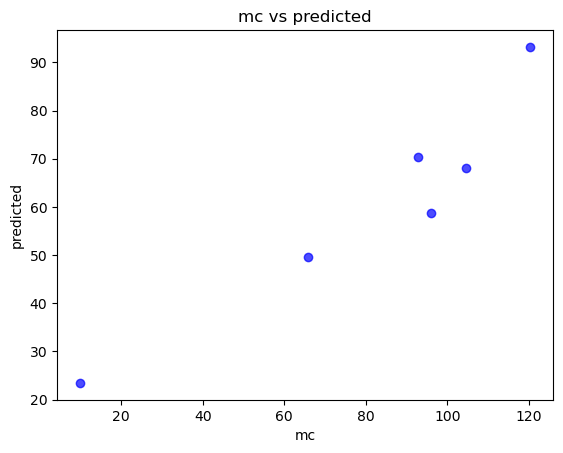

R2: 0.43
MSE: 735.34


In [25]:
images = np.array([A1, A2, A3, A4, A5, A6])  # 画像データをNumPy配列に格納
mc = np.array(mc)  # 含水率データをNumPy配列に格納

# ①CNNモデルの定義
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(120, 90, 3)),  # 畳み込み層
    MaxPooling2D((2, 2)),  # プーリング層
    Conv2D(64, (3, 3), activation='relu'),  # 畳み込み層
    MaxPooling2D((2, 2)),  # プーリング層
    Conv2D(64, (3, 3), activation='relu'),  # 畳み込み層
    Flatten(),  # 平坦化層
    Dense(64, activation='relu'),  # 全結合層
    Dense(1)  # 出力層
])

# ②モデルのコンパイル
model.compile(optimizer='adam', loss='mean_squared_error')  # 最適化アルゴリズムと損失関数の設定
model.summary()  # ③モデルの構造を表示
# モデルの学習
model.fit(images, mc, epochs=10)  #④画像データと含水率データでモデルを学習

# 含水率の予測
mc_pred = model.predict(images).flatten()  #⑤画像データから含水率を予測

# 予測値と実測値の散布図のプロット
plt.scatter(mc, mc_pred, alpha=0.7, color='blue')
plt.xlabel('mc')
plt.ylabel('predicted')
plt.title('mc vs predicted')
plt.show()

# R2とMSEの計算
r2 = r2_score(mc, mc_pred)  # 決定係数R2の計算
mse = mean_squared_error(mc, mc_pred)  # 平均二乗誤差MSEの計算
print(f'R2: {r2:.2f}')
print(f'MSE: {mse:.2f}')


### <span style="color: DeepPink; "> appendix opencvによるコインの検出</span>

検出されたコイン数：4個
contour: 0, size: 13018.0, centroid: (90.85, 344.84)
contour: 1, size: 9145.0, centroid: (90.30, 174.22)
contour: 2, size: 8212.5, centroid: (245.94, 130.63)
contour: 3, size: 8210.0, centroid: (337.12, 61.76)


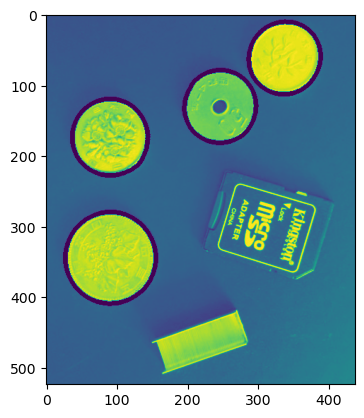

In [26]:
# ファイルを読み込み グレースケール化
img = cv2.imread("dataChapter8/coin.jpg", cv2.IMREAD_GRAYSCALE)
# 二値化
_, threshold = cv2.threshold(img, 160, 255, cv2.THRESH_BINARY)
# 輪郭を抽出
contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE ) 
# 微小な輪郭を削除
contours2 = list(filter(lambda x: cv2.contourArea(x) >= 100, contours))
# 円以外を除去したい
contours3 = []
for cnt in contours2:
    # 輪郭線の長さを計算
    arclen = cv2.arcLength(cnt, True)
    # 輪郭線の近似
    approx = cv2.approxPolyDP(cnt, 0.01 * arclen, True)
# 　　八角形以上を円とみなしてcontours3に格納
    if len(approx)>8:
        contours3.append(cnt)
# 結果表示
print(f"検出されたコイン数：{len(contours3)}個")
for i, cnt in enumerate(contours3):
    # 輪郭の面積を計算する。
    area = cv2.contourArea(cnt)
    # 輪郭のモーメントを計算する。
    M = cv2.moments(cnt)
    # モーメントから重心を計算する。
    cx = M["m10"] / M["m00"]
    cy = M["m01"] / M["m00"]
    print(f"contour: {i}, size: {area}, centroid: ({cx:.2f}, {cy:.2f})")

cv2.drawContours(img, contours3, -1,2,5)
plt.imshow(img)